# Getting the Agent Rotations 

--> will be interpolated even when the agents are not present so continous data cannot be used

In [1]:
import pandas as pd  # operate with dataframes
import scipy.io  # to load Matlab data
import matplotlib.pyplot as plt  # mother of plots for Python
import seaborn as sns  
import numpy as np  # array/matrix operations (e.g. linear algebra)
from cmcrameri import cm
import scipy.signal
import pyxdf
from scipy.ndimage import gaussian_filter1d
from statsmodels import robust
from scipy.stats import median_abs_deviation
from PIL import Image
from scipy.stats import f_oneway
from scipy.io import savemat
import random
import os.path
# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from multiprocessing.dummy import Pool as ThreadPool  # Thread-based parallelism
from tqdm.notebook import tqdm  # mother of progressbars
import math
import re
import matplotlib.patches as patches

In [2]:
PATH_REPO = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline"
PATH_FOREYE = f"{PATH_REPO}/data/village/processed/MAD_sacc_newfile" # new path, potentially change
PATH_TRG = f"{PATH_REPO}/data/village/processed/Trigger_MAD_newfile"
PATH_MATLABPLOTS = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed/face_paper"
PATH_ERPS = "/net/store/nbp/projects/wd_ride_village/processedData/village/preprocessed/"
PATH_EEG = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed/EEG"
PATH_PROC = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed"
PATH_RAW = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/raw"
PATH_AGNT = "/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/data/village/processed/AgentInfo"


In [3]:
recordings = pd.read_csv(f"{PATH_REPO}/recordings_village.csv", index_col=0)
# only keep the subjects we will include in the paper!

subs_to_include = [1,4,5,11,16,18,19,20,21,29,30,33,34,36,37,38,41,
                   42,43,44,45,46,47,48,49,50,53,54,56,57,58,59,60]


recordings["files"] = [
    int(f[:2]) if int(f[:2]) in subs_to_include else 0
    for f in recordings["file"]
]

recordings = recordings[recordings["files"] > 0]

recordings = recordings.drop("files", axis=1)



In [4]:
# agent streams
AGENTS = [
    "AgentRotation",
    #"StaticAgentPosition",
    "StaticAgentRotation",
    #"AgentPosition",
]

# streams to remove
REMOVE = [
    "openvibeSignal",
    "openvibeMarkers",
    "AgentRotation",
    "StaticAgentPosition",
    "StaticAgentRotation",
    "AgentPosition",
    "ValidationError",
    "ButtonPresses",
    "PlayerPosition",
]

# Preprocess Agent Rotations

In [100]:
#e9b010ec-29a3-4084-88e8-832f8e33a6c8

ids[22:23]

['e9b010ec-29a3-4084-88e8-832f8e33a6c8']

In [89]:

ids = recordings.index.tolist()
idd = ids[:]

for uid in idd:
    print(uid)
    # Load participant-specific data
    
    part = recordings.loc[uid].file
    data, _ = pyxdf.load_xdf(f"{PATH_RAW}/{part}")
    
    # Filter out only relevant agent data
    agent_data = [d for d in data if d["info"]["name"][0] in AGENTS]

    # Extract timestamps and filter necessary streams
    valid_data = [d for d in data if d["info"]["name"][0] not in REMOVE]
    to_sub = min(d["time_stamps"][0] for d in valid_data)
    
    
     # Collect unique timestamps for static and moving agents
    common_times = []  # for static agents

    # Loop through agent data to collect unique timestamps for static and moving agents
    for s in agent_data:
        s_name = s["info"]["name"][0]
        times = np.array(s["time_stamps"]) - to_sub  # Adjust timestamps by subtracting from the REMOVE streams
        times = np.round(times, 3)  # Round to 3 decimal places and remove duplicates
        times = np.unique(times)
        common_times.extend(times)

    # Remove duplicates and sort the timestamps for static and moving agents
    common_times = np.sort(np.unique(common_times))
    common_times = np.round(np.arange(common_times[0], common_times[-1], 0.001),3)
    
    ped_df = []
    # Load pedestrian distribution data
    ped_dist = pd.read_csv(f"/net/store/nbp/projects/wd_ride_village/repos/wd-pilot-pipeline/Overview_pedestrians_distrubtion.csv", index_col=0)
    ped_dist = ped_dist[~ped_dist.index.duplicated(keep="first")]  # Drop duplicate entries
    ped_names = ped_dist.index.tolist()

    # Iterate over each pedestrian to create relevant DataFrames
    for ped in ped_names[:]:  # You can adjust the range as needed
        # Determine the index based on the pedestrian name
        index = ped if ped != "35 (34.1)" else "35"
        index = str(round(float(index)))  # Convert the index to a string and round to the
        
        # Determine if the pedestrian is moving or static
        if ped_dist.loc[ped]["Moving"] == 1.0:
            AG = ["AgentRotation"]
        else:
            AG = ["StaticAgentRotation"]

        # Extract the required streams based on the pedestrian's movement status
        data_ped = [d for d in agent_data if d["info"]["name"][0] in AG]
        # get the time of this recording
        times = np.round(np.array(data_ped[0]["time_stamps"]) - to_sub,3)
        # get the ped_names of this recording
        ped_names = np.round(np.array(data_ped[0]["time_series"][:, 0], dtype=float),3)
        # get the rotations of this recording
        ped_rotations = np.round(np.array(data_ped[0]["time_series"][:, 1], dtype=float),3)
        df_ped = pd.DataFrame({
            'Time': times,
            'Pedestrian': ped_names,
            'Rotation': ped_rotations
        })

        
        # Dreate df for this ped full of nans as long as common_times
        aligned_data = {f"{index}": np.full_like(common_times, np.nan, dtype=float)}

        filtered_df = df_ped[df_ped['Pedestrian'] == float(index)]
        # now let's fomd all corresponding timestamps --> so we know where to put the rotation data
        time_values = filtered_df['Time'].to_numpy()
        # Find matching indices of common_times in time_values
        matching_indices = np.searchsorted(common_times, time_values, side='left')
        matching_indices = np.clip(matching_indices, 0, len(common_times) - 1)
        # now add the rotation data into aligned_data
        aligned_data[f"{index}"][matching_indices] = filtered_df['Rotation'].to_numpy()
        valid_indices = np.where(~pd.isna(aligned_data[f"{index}"]))[0]
        time_diffs = np.diff(time_values) # get the distance between present timepoints
        large_gaps = np.where(time_diffs > 0.04)[0]  # Large gaps > 40 ms 
        # now lets get the intervals we have to set to nan after interpolation
        if len(large_gaps) > 0:
            # now we need to get the start and end indicies of the data to not be interpolated
            if matching_indices[0] != 0:
                start_idx = [0]
                end_idx = [matching_indices[0]]
            else:
                start_idx = []
                end_idx = []
            for gap in large_gaps:
                start_idx = start_idx + [matching_indices[gap-1]]
                end_idx = end_idx + [matching_indices[gap]]
            if matching_indices[-1] != len(common_times):
                start_idx = start_idx + [matching_indices[-1]]
                end_idx = end_idx + [len(common_times)]
        # Ensure start_idx and end_idx are NumPy arrays for vectorized operations
        start_idx = np.array(start_idx)
        end_idx = np.array(end_idx)
        
        # Apply interpolation only for small gaps
        aligned_data[f"{index}"] = pd.Series(aligned_data[f"{index}"]).interpolate(method="linear").to_numpy()
        
        # not we set all the large gaps to nan again
        for i in range(len(start_idx)):
            aligned_data[f"{index}"][start_idx[i]:end_idx[i]] = np.nan

        aligned_data = pd.DataFrame(aligned_data, index=common_times)
        ped_df.append(aligned_data) # add it to the big df

    # Once all pedestrians' data for the current participant are processed, concatenate the DataFrames
    if ped_df:
        df_ped = pd.concat(ped_df, axis=1)

        # kick out the rows where the data is not needed
        # load the behavioral data
        for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
        for_eye = for_eye[for_eye.time <= df_ped.index.tolist()[-1]] 
        for_eye = for_eye[for_eye.time >= df_ped.index.tolist()[0]] 
        df_ped = df_ped.loc[for_eye.time] # only keep relevant rows
        df_ped.to_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index=True)


70656182-09b3-4c19-9ae2-0a2ab2e19fed
c924cc42-5987-4025-b026-c672e304599f
20e8d35c-e7aa-4be3-a6e2-5b78f4cd44d8
1dea5bd2-80d1-4068-b512-99c55f85f44c
e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7
289c15b5-ddd9-442b-b6b6-78df542beb3a
61c0f1aa-b3ef-497b-8b6e-8ec6f05f6c42
391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3
95184b7a-42f1-40b0-ae36-be6ef1e33f1d
c4cb86a2-c2d6-40f0-b594-9bb3eb769189
b3cee177-543e-4398-9075-5b671eed84ab
623664e8-1ceb-48e0-abd0-46d447285980
f25b9349-573e-4c97-974e-855d4b037c79
0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab
817cb93e-061d-4ea6-a13d-31226246ff34
6f6719eb-8c89-46fe-8b5e-3c81e0e40a84
42785e0b-efab-44a1-8c9f-bab59edcc93e
d6610468-645c-4e29-bef0-ce2ad45a5c3f
6264954d-ddee-4eff-b8d6-887fb28524f9
653c0570-e662-47a1-89ea-d2125edc680e
312425d7-bb57-49dc-9107-b6462b3c176c
16ae5535-ea8c-4ae2-9195-ef3abf811f97
e9b010ec-29a3-4084-88e8-832f8e33a6c8
983f9d22-737a-4087-b812-3b1ce7e29fed
3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1
9c8b7189-b11a-4014-a2ea-3848cc68e7e3
4facb3ab-dfba-4953-b266-6368edac48d3
a

# Compute the Viewing Angel

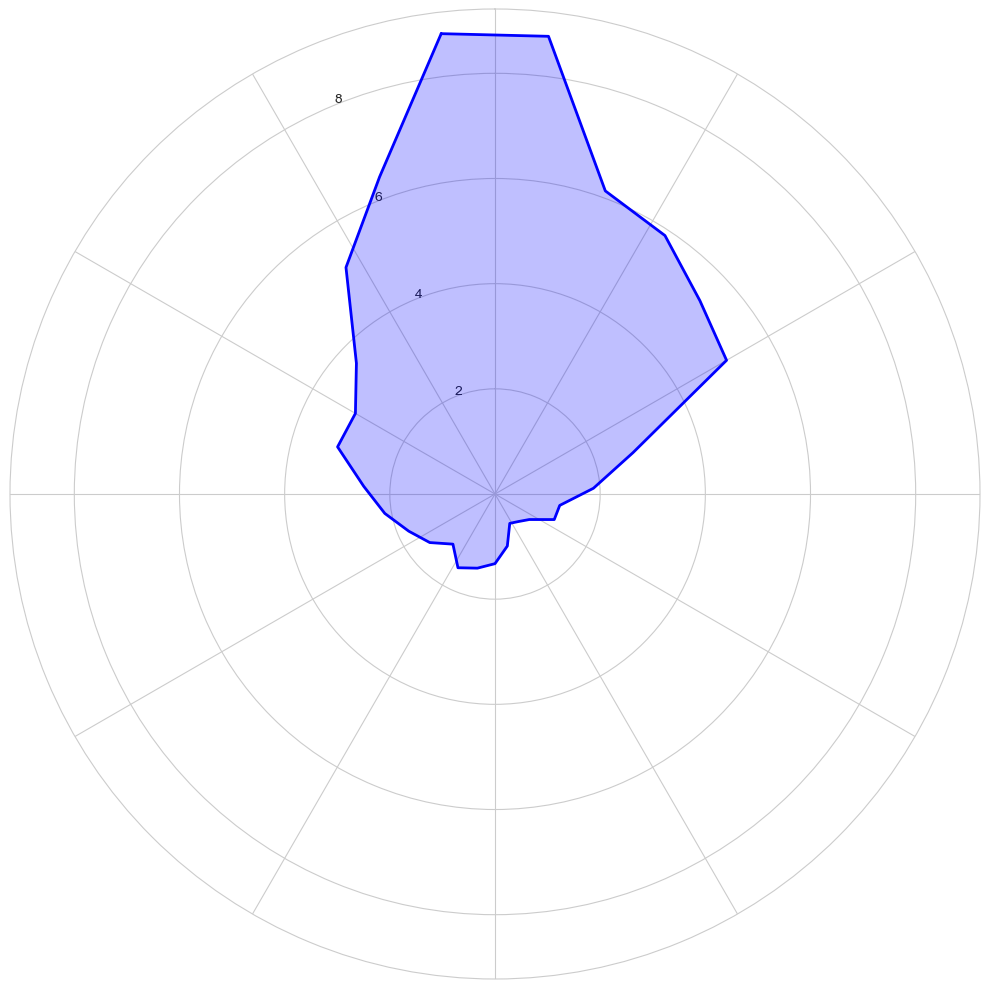

In [31]:
# just plot the average across subjects
ids = recordings.index.tolist()
idd = ids[:]


# Initialize data storage for averaging
all_histograms = []
num_participants = len(idd)

for uid in idd:
    
   
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

     # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows


    viewing_angle = []
    for r in range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        viewing_angle = viewing_angle + [(rotations[curr_name].tolist()[r] - yaw + 180) % 360]


    # Create a histogram of frequencies of viewing angles for participant
    bins = np.linspace(0, 360, num=28)  # 36 bins for 10-degree intervals (0-360)
    hist, edges = np.histogram(viewing_angle, bins=bins, density=False)

    # Calculate percentages
    total_count = np.sum(hist)  # Calculate the total count of observations
    percentage_hist = (hist / total_count) * 100  # Convert counts to percentages
   # Store histogram data for averaging later
    all_histograms.append(percentage_hist)

# Convert list of histograms to a numpy array for easier manipulation
all_histograms = np.array(all_histograms)

# Calculate average histogram across participants
average_histogram = np.median(all_histograms, axis=0)
# Calculate angles for polar plot based on the bins
angles = edges[:-1] + np.diff(edges) / 2  # Midpoints for each bin
angles = np.concatenate((angles, [angles[0]]))  # Close the circle
average_histogram = np.concatenate((average_histogram, [average_histogram[0]]))  # Repeat first value to close the circle

# Create a polar plot for the average distribution
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = plt.subplot(projection='polar')  # Create a polar subplot
ax.plot(np.deg2rad(angles), average_histogram, 'b', linewidth=2)  # Line plot
ax.fill(np.deg2rad(angles), average_histogram, color='b', alpha=0.25)  # Fill the area

# Set the labels and title for the entire plot
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Ticks every 30 degrees
ax.set_xticklabels([f"{int(angle)}°" for angle in np.arange(0, 360, 30)], fontsize=14)

ax.set_theta_zero_location("N")  # 0° (North) at the top
#ax.set_xticks(np.radians([0, 90, 180, 270]))  
#ax.set_yticklabels([])  # Hide radial labels

# Set labels at 0°, 90°, 180°, 270°
#ax.set_xticks(np.radians([0, 90, 180, 270]))  
#ax.set_xticklabels(["0° (Front)", "90° (Right)", "180° (Back)", "270° (Left)"], fontsize=14)
ax.set_xticklabels([])


plt.tight_layout()
#plt.savefig("./images/rot_plot_mean_37bins.png", bbox_inches="tight", pad_inches=0.3, dpi=400)  
plt.show()

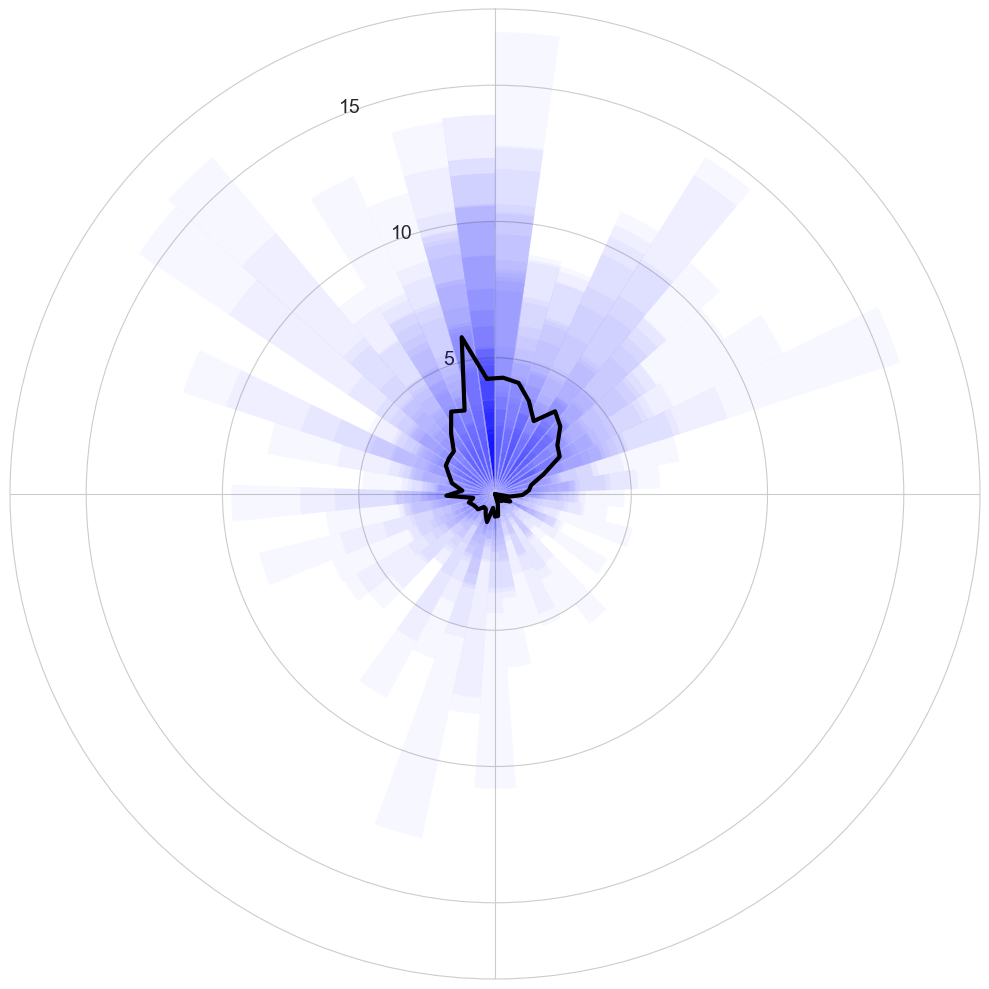

In [24]:
### Plot all subjects!!

# participants ids
ids = recordings.index.tolist()
idd = ids[:]

# Create a polar plot for the average distribution
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = plt.subplot(projection='polar')  # Create a polar subplot

# Initialize data storage for averaging
all_histograms = []
num_participants = len(idd)

for uid in idd:
    
   
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

     # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows


    viewing_angle = []
    for r in range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        viewing_angle = viewing_angle + [(rotations[curr_name].tolist()[r] - yaw + 180) % 360]


    # Create a histogram of frequencies of viewing angles for participant
    bins = np.linspace(0, 360, num=46)  # 36 bins for 10-degree intervals (0-360)
    hist, edges = np.histogram(viewing_angle, bins=bins, density=False)

    # Calculate percentages
    total_count = np.sum(hist)  # Calculate the total count of observations
    percentage_hist = (hist / total_count) * 100  # Convert counts to percentages
    all_histograms.append(percentage_hist)

    # Calculate angles for polar plot based on the bins
    angles = edges[:-1] + np.diff(edges) / 2  # Midpoints for each bin
    angles = np.concatenate((angles, [angles[0]]))  # Close the circle
    percentage_hist = np.concatenate((percentage_hist, [percentage_hist[0]]))  # Repeat first value to close the circle
    
    #width = np.deg2rad(np.diff(edges))
    # Append the last width value to close the circle
    #width = np.concatenate((width, [width[-1]]))
    width = (2 * np.pi) / len(hist) *1.01 # 
    #ax.plot(np.deg2rad(angles), percentage_hist, 'b', linewidth=1, alpha=0.4)  # Line plot
    ax.bar(np.deg2rad(angles), percentage_hist, width=width, color='b', alpha=0.03)  # Fill the area

    

all_histograms = np.array(all_histograms)
average_histogram = np.median(all_histograms, axis=0)
# Calculate angles for polar plot based on the bins
angles = edges[:-1] + np.diff(edges) / 2  # Midpoints for each bin
angles = np.concatenate((angles, [angles[0]]))  # Close the circle
average_histogram = np.concatenate((average_histogram, [average_histogram[0]]))  # Repeat first value to close the circle
ax.plot(np.deg2rad(angles), average_histogram, 'k', linewidth=3)  # Line plot

# Set the labels and title for the entire plot
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Ticks every 30 degrees
ax.set_xticklabels([f"{int(angle)}°" for angle in np.arange(0, 360, 30)], fontsize=14)

ax.set_theta_zero_location("N")  # 0° (North) at the top
ax.set_yticks(np.arange(0, 20,5))  # Example with ticks up to the maximum value
ax.set_yticklabels(['','5', '10', '15',], fontsize=14)  # Customize font size
#ax.set_yticklabels([])  # Hide radial labels

# Set labels at 0°, 90°, 180°, 270°
ax.set_xticks(np.radians([0, 90, 180, 270]))  
#ax.set_xticklabels(["0° (Front)", "90° (Right)", "180° (Back)", "270° (Left)"], fontsize=14)
ax.set_xticklabels([])


plt.tight_layout()
#plt.savefig("./images/rot_plot_allsubs_bars_45.png", bbox_inches="tight", pad_inches=0.3, dpi=400)  
plt.show()

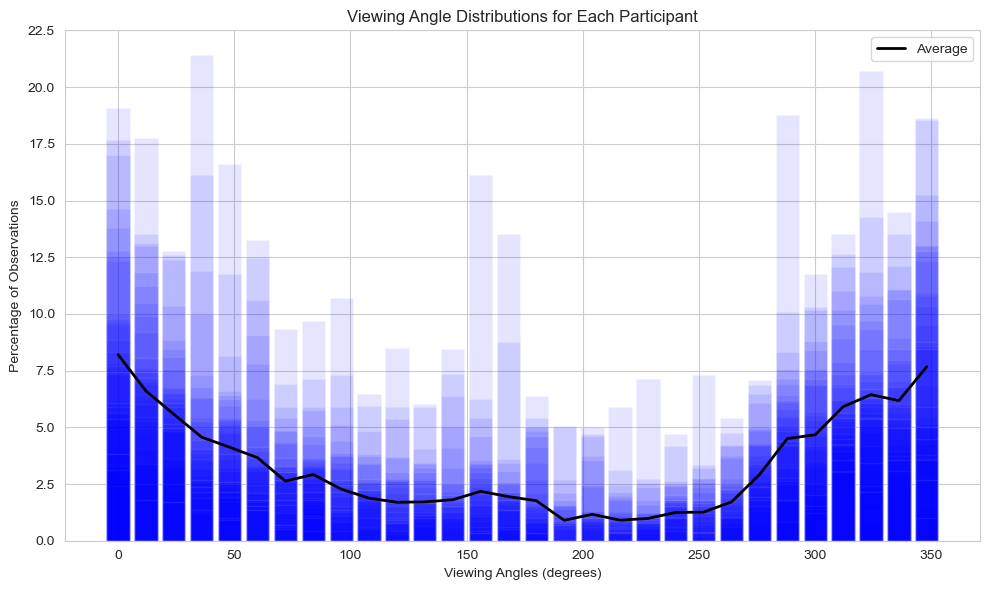

In [41]:
# Sample Data Load (ensure this fits your actual data structure)
ids = recordings.index.tolist()
idd = ids[:]  # All participants

# Initialize figure for histogram plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Initialize data storage for averaging
all_histograms = []

for uid in idd:
    # Load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    
    # Get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[~gaze["long_events"].isnull()]
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

    # Get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time]  # Only keep relevant rows

    viewing_angle = []
    for r in range(len(face_gaze)):
        # Compute the participants' gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        if yaw < 0:
            yaw += 360

        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        viewing_angle.append((rotations[curr_name].tolist()[r] - yaw + 180) % 360)

    # Create a histogram of frequencies of viewing angles for participant
    bins = np.linspace(0, 360, num=31)  # 36 bins for 10-degree intervals (0-360)
    hist, edges = np.histogram(viewing_angle, bins=bins, density=False)

    # Calculate percentages
    total_count = np.sum(hist)  # Total count of observations
    percentage_hist = (hist / total_count) * 100  # Convert counts to percentages
    all_histograms.append(percentage_hist)

    # Plot individual participant's distribution
    plt.bar(edges[:-1], percentage_hist, width=10, alpha=0.1, color='b')  # Plotting the histogram directly

# Optionally to plot average histogram across participants if needed
average_histogram = np.mean(np.array(all_histograms), axis=0)
plt.plot(edges[:-1], average_histogram, color='k', linewidth=2, label='Average')

# Labels and title
plt.xlabel('Viewing Angles (degrees)')
plt.ylabel('Percentage of Observations')
plt.title('Viewing Angle Distributions for Each Participant')
plt.legend()
plt.tight_layout()
plt.savefig("./images/rot_plot_histogram.png", bbox_inches="tight", pad_inches=0.3, dpi=400)
plt.show()

# Display the distances kept at head fixations

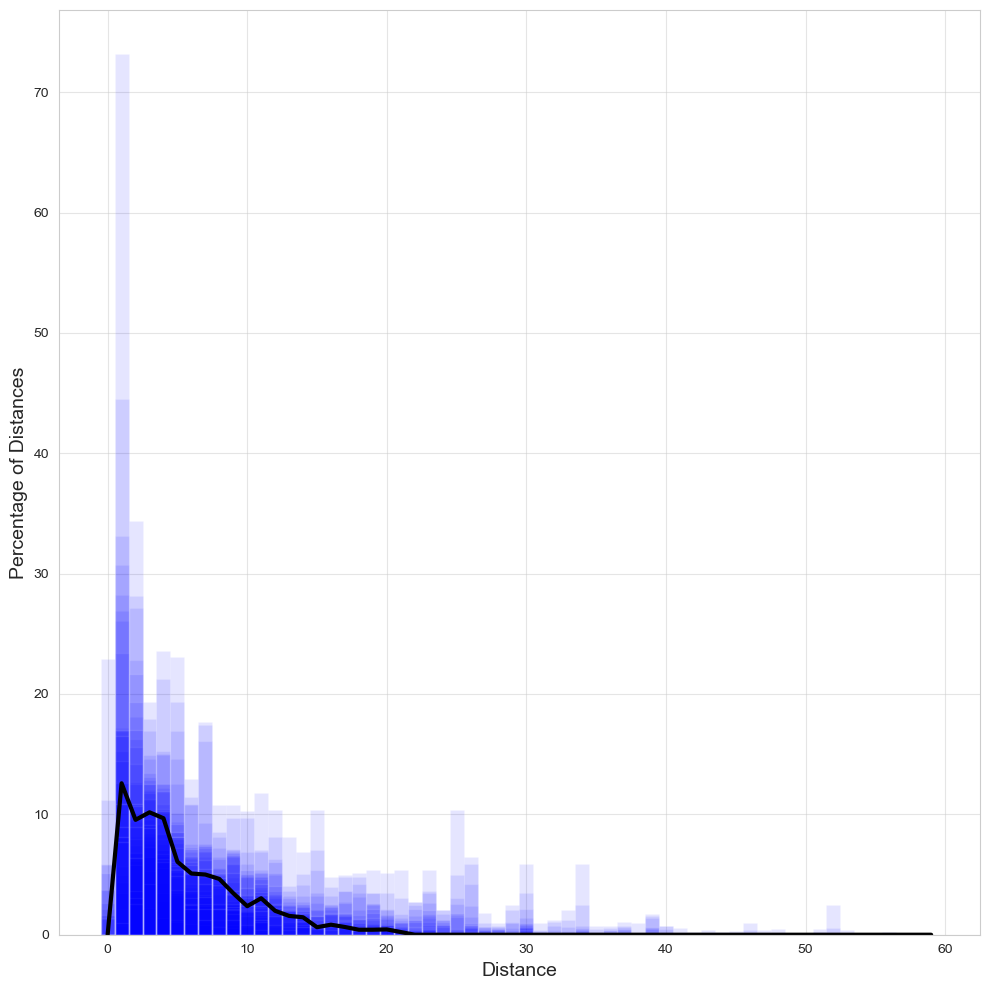

In [20]:
### Plot all subjects!!

# participants ids
ids = recordings.index.tolist()
idd = ids[:]

# Create a polar plot for the average distribution
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

# Initialize data storage for averaging
all_histograms = []
num_participants = len(idd)

for uid in idd:
    
   
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

    # Create a histogram of frequencies of viewing angles for participant
    bins = np.linspace(0, 60, num=61)  # 36 bins for 10-degree intervals (0-360)
    hist, edges = np.histogram(face_gaze.distance.tolist(), bins=bins, density=False)

    # Calculate percentages
    total_count = np.sum(hist)  # Total count of observations
    percentage_hist = (hist / total_count) * 100  # Convert counts to percentages
    all_histograms.append(percentage_hist)

    # Plot individual participant's distribution
    plt.bar(edges[:-1], percentage_hist, width=np.diff(edges), alpha=0.1, color='b')  # Plotting the histogram directly
    

all_histograms = np.array(all_histograms)
average_histogram = np.median(all_histograms, axis=0)
plt.plot(edges[:-1], average_histogram, 'k', linewidth=3)  # Line plot

plt.xlabel("Distance", fontsize=14)
plt.ylabel("Percentage of Distances", fontsize=14)

plt.grid(alpha=0.5)
plt.tight_layout()
#plt.savefig("./images/rot_plot_allsubs_bars_45.png", bbox_inches="tight", pad_inches=0.3, dpi=400)  
plt.show()


# Interaction between Angel and Distance

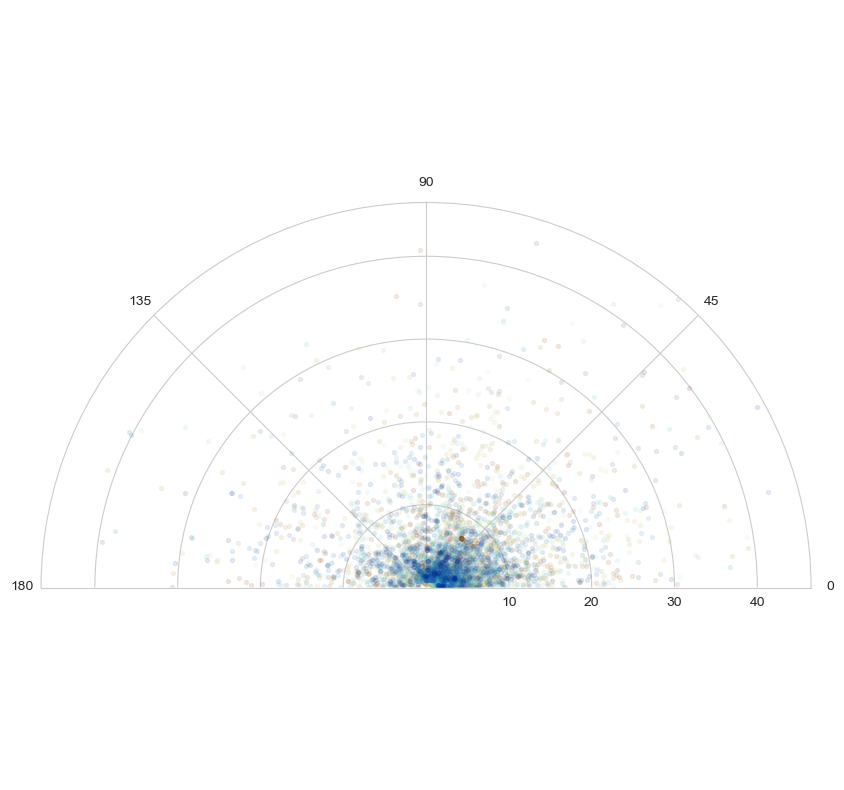

In [116]:
# participants ids
ids = recordings.index.tolist()
idd = ids[:]


# Create a polar plot for the average distribution
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = plt.subplot(projection='polar')  # Create a polar subplot
color = iter(cm.roma(np.linspace(0, 1, len(idd))))



for uid in idd:
    # Load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[~gaze["long_events"].isnull()]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

    # Get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time]  # Keep relevant time rows

    distances = face_gaze.distance.tolist()
    
    viewing_angle = []
    for r in range(len(face_gaze)):
        # Compute gaze direction
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        if yaw < 0:
            yaw += 360

        # Current pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)

        # Calculate the viewing angle
        angel = (rotations[curr_name].tolist()[r] - yaw + 180) % 360
        
        if angel > 180:
            angel = 360-angel
            
        viewing_angle.append(angel)

    
    average_distances = {}
    # Store angles and distances for the average across 
    for angle, distance in zip(viewing_angle, distances):
        if angle not in average_distances:
            average_distances[angle] = []
        average_distances[angle].append(distance)

    angles = sorted(average_distances.keys())
    avg_distances = [np.mean(average_distances[angle]) for angle in angles]

    # Convert angles for polar plot and plot
    theta = np.deg2rad(np.array(angles))
    c = next(color)

    ax.scatter(theta, avg_distances, facecolor=c, alpha=0.1, s=8, edgecolor=None)


#plt.xlabel("Viewing Angle (degrees)")
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim(0, max(max(avg_distances)+1, 1))  # Adjust depending on distances
ax.set_xticks(np.deg2rad(np.array([0, 45, 90, 135, 180])))  # Show angles in radians
ax.set_xticklabels([0, 45, 90, 135, 180])  # Set ticks back to degrees
ax.set_yticks(np.arange(0, 45,10))  # Example with ticks up to the maximum value
ax.set_yticklabels(['','10', '20', '30','40'], fontsize=14)  # Customize font size

plt.show()      

In [164]:
np.linspace(0, 180, num=10)  # Define the angle bins

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [118]:
len(np.linspace(0, 360, num=46))

46

'\naverage_distances = {}\n# Store angles and distances for the average across \nfor angle, distance in zip(viewing_angle, distances):\n    if angle not in average_distances:\n        average_distances[angle] = []\n    average_distances[angle].append(distance)\n\nangles = sorted(average_distances.keys())\navg_distances = [np.mean(average_distances[angle]) for angle in angles]\n\n# Convert angles for polar plot and plot\ntheta = np.deg2rad(np.array(angles))\nc = next(color)\n\nax.scatter(theta, avg_distances, facecolor=c, alpha=0.1, s=8, edgecolor=None)\n\n\n#plt.xlabel("Viewing Angle (degrees)")\nax.set_thetamin(0)\nax.set_thetamax(180)\nax.set_ylim(0, max(max(avg_distances)+1, 1))  # Adjust depending on distances\nax.set_xticks(np.deg2rad(np.array([0, 45, 90, 135, 180])))  # Show angles in radians\nax.set_xticklabels([0, 45, 90, 135, 180])  # Set ticks back to degrees\nax.set_yticks(np.arange(0, 45,10))  # Example with ticks up to the maximum value\nax.set_yticklabels([\'\',\'10\', \'

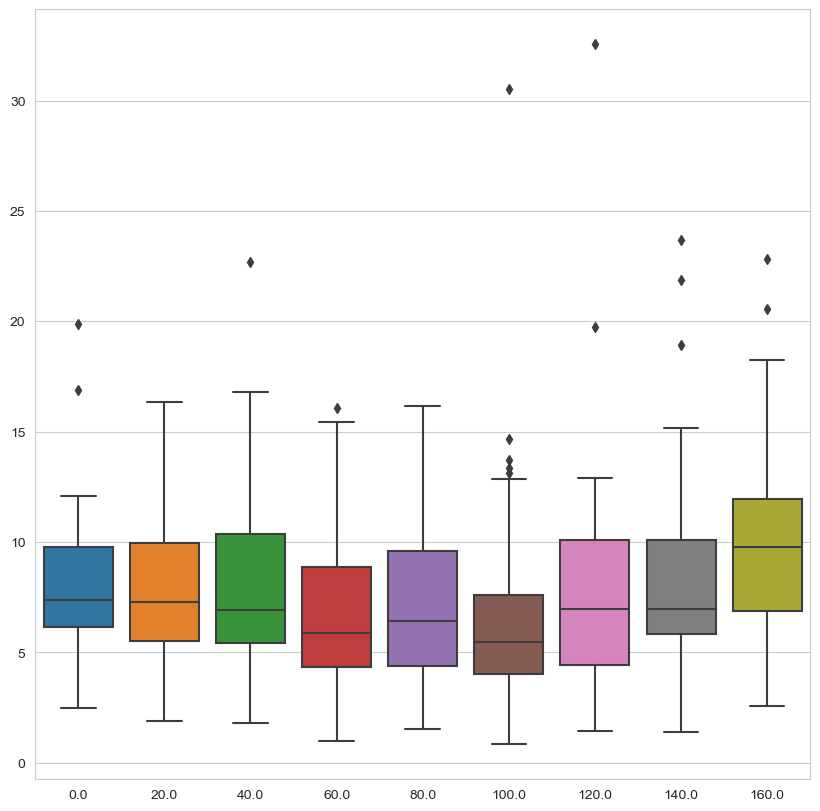

In [170]:
# participants ids
ids = recordings.index.tolist()
idd = ids[:]


# Create a polar plot for the average distribution
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

angle_bins = np.linspace(0, 180, num=10)  # Define the angle bins
average_distances = {angle: [] for angle in angle_bins} # dict across subject
for uid in idd: 
    # Load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[~gaze["long_events"].isnull()]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

    # Get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time]  # Keep relevant time rows

    distances = face_gaze.distance.tolist()
    
    viewing_angle = []
    for r in range(len(face_gaze)):
        # Compute gaze direction
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        if yaw < 0:
            yaw += 360

        # Current pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)

        # Calculate the viewing angle
        angel = (rotations[curr_name].tolist()[r] - yaw + 180) % 360
        
        if angel > 180:
            angel = 360-angel
            
        viewing_angle.append(angel)
    
    sum_distances = {angle: [] for angle in angle_bins} # dict to save the distances in
    # Store angles and distances for the average across 
    for angle, distance in zip(viewing_angle, distances):
        # get the correct bin
        a = np.digitize(angle,angle_bins,right=False)-1
        # save the distance in the corresponding bin
        sum_distances[angle_bins[a]].append(distance) 
        
    # now get the average for each subject and add it to the list
    for dist in sum_distances:
        if len(sum_distances[dist]) > 0:
            average_distances[dist].append(np.mean(sum_distances[dist]))
        else:
            average_distances[dist].append(np.nan)
average_distances = pd.DataFrame(average_distances).drop(columns=[180])
sns.boxplot(average_distances)

'''
average_distances = {}
# Store angles and distances for the average across 
for angle, distance in zip(viewing_angle, distances):
    if angle not in average_distances:
        average_distances[angle] = []
    average_distances[angle].append(distance)

angles = sorted(average_distances.keys())
avg_distances = [np.mean(average_distances[angle]) for angle in angles]

# Convert angles for polar plot and plot
theta = np.deg2rad(np.array(angles))
c = next(color)

ax.scatter(theta, avg_distances, facecolor=c, alpha=0.1, s=8, edgecolor=None)


#plt.xlabel("Viewing Angle (degrees)")
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim(0, max(max(avg_distances)+1, 1))  # Adjust depending on distances
ax.set_xticks(np.deg2rad(np.array([0, 45, 90, 135, 180])))  # Show angles in radians
ax.set_xticklabels([0, 45, 90, 135, 180])  # Set ticks back to degrees
ax.set_yticks(np.arange(0, 45,10))  # Example with ticks up to the maximum value
ax.set_yticklabels(['','10', '20', '30','40'], fontsize=14)  # Customize font size

plt.show()      
'''

In [155]:
display(pd.DataFrame(average_distances).drop(columns=[180]))

,0.000000,8.181818,16.363636,24.545455,32.727273,40.909091,49.090909,57.272727,65.454545,73.636364,...,98.181818,106.363636,114.545455,122.727273,130.909091,139.090909,147.272727,155.454545,163.636364,171.818182
0,10.201016,5.025985,8.092405,NaN,17.075972,2.303089,5.325025,6.244121,4.268447,NaN,...,7.955622,NaN,3.965828,NaN,4.496645,2.724407,5.663137,10.433711,NaN,NaN
1,10.453978,13.195625,4.399465,11.566103,14.318919,NaN,NaN,4.906212,9.304860,1.885009,...,NaN,NaN,NaN,11.803892,6.846787,NaN,NaN,NaN,10.853644,17.101300
2,4.796266,5.670896,6.628753,5.719173,7.857760,5.908863,6.235738,4.588159,4.866684,4.852599,...,3.699343,4.492165,11.064045,7.551880,4.804524,11.728460,9.683755,NaN,NaN,9.776647


# Next step: create trigger files with frontal faces & Distances

In [60]:
# participants ids
ids = recordings.index.tolist()
idd = ids[:]


for uid in idd:
    display(uid)

    # load old trigger file
    trigger = pd.read_csv(f"{PATH_TRG}/try_TriggerFile_saccadeOnset_{uid}.csv")

    # load old trigger file
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)

    # create triggers as done in the code before to get the correct time line!
    gaze = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)].copy()
    gaze["time_sac"] = gaze["time"].shift(1)
    gaze = gaze[gaze["time_sac"].notna()]
    gaze = gaze[gaze["events"] == 2.0]
    gaze = gaze[~gaze["long_events"].isnull()]  
    # set the time to the trigger file
    trigger["time"] = gaze["time"].tolist()
    
    # now, let's calculate the rotations
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)].copy()
    # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows
    viewing_angle = []
    for r in range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        viewing_angle = viewing_angle + [(rotations[curr_name].tolist()[r] - yaw + 180) % 360]
    
    face_gaze.loc[:,"viewing_angle"] = viewing_angle
    # now only keep the frontal face gazes
    face_gaze = face_gaze[(face_gaze["viewing_angle"] < 45) | (face_gaze["viewing_angle"] >= 315)].copy()
    print(len(face_gaze))
    # and exchange them in the trigger file
    trigger.loc[trigger['time'].isin(face_gaze['time']), 'type'] = 10
    # delete the time axis
    trigger = trigger.drop('time', axis=1)
    trigger.to_csv(f"{PATH_TRG}/frontal_face_triggers_10_{uid}.csv", index=False)


'70656182-09b3-4c19-9ae2-0a2ab2e19fed'

30


'c924cc42-5987-4025-b026-c672e304599f'

18


'20e8d35c-e7aa-4be3-a6e2-5b78f4cd44d8'

92


'1dea5bd2-80d1-4068-b512-99c55f85f44c'

85


'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7'

11


'289c15b5-ddd9-442b-b6b6-78df542beb3a'

72


'61c0f1aa-b3ef-497b-8b6e-8ec6f05f6c42'

19


'391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3'

55


'95184b7a-42f1-40b0-ae36-be6ef1e33f1d'

85


'c4cb86a2-c2d6-40f0-b594-9bb3eb769189'

61


'b3cee177-543e-4398-9075-5b671eed84ab'

19


'623664e8-1ceb-48e0-abd0-46d447285980'

151


'f25b9349-573e-4c97-974e-855d4b037c79'

131


'0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab'

564


'817cb93e-061d-4ea6-a13d-31226246ff34'

63


'6f6719eb-8c89-46fe-8b5e-3c81e0e40a84'

198


'42785e0b-efab-44a1-8c9f-bab59edcc93e'

33


'd6610468-645c-4e29-bef0-ce2ad45a5c3f'

97


'6264954d-ddee-4eff-b8d6-887fb28524f9'

77


'653c0570-e662-47a1-89ea-d2125edc680e'

94


'312425d7-bb57-49dc-9107-b6462b3c176c'

195


'16ae5535-ea8c-4ae2-9195-ef3abf811f97'

28


'e9b010ec-29a3-4084-88e8-832f8e33a6c8'

7


'983f9d22-737a-4087-b812-3b1ce7e29fed'

66


'3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1'

126


'9c8b7189-b11a-4014-a2ea-3848cc68e7e3'

16


'4facb3ab-dfba-4953-b266-6368edac48d3'

53


'ac35237b-e4b2-4744-bd17-02f44c3f6139'

110


'cac2d463-04e5-400f-92fb-d731d1f31e79'

163


'e73b2026-7205-48b2-a1e4-7434a8c918f6'

25


'0b462e46-9a87-4e70-ab1d-0f53c35726ec'

29


'3fa44c7e-1ea4-4625-9576-b489cfc918b3'

107


'ea12ade9-532c-4a5f-b5c5-38ee71a59b9f'

133


In [176]:
# participants ids
ids = recordings.index.tolist()
idd = ids[:]


for uid in idd:
    display(uid)

    # load old trigger file
    trigger = pd.read_csv(f"{PATH_TRG}/try_TriggerFile_saccadeOnset_{uid}.csv")

    # load old trigger file
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)

    # create triggers as done in the code before to get the correct time line!
    gaze = for_eye[(for_eye["events"] == 2.0) |(for_eye["events"] == 1.0)].copy()
    gaze["time_sac"] = gaze["time"].shift(1)
    gaze = gaze[gaze["time_sac"].notna()]
    gaze = gaze[gaze["events"] == 2.0]
    gaze = gaze[~gaze["long_events"].isnull()]  
    # set the time to the trigger file
    trigger["time"] = gaze["time"].tolist()
    
    # now, let's calculate the rotations
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)].copy()
    # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows
    viewing_angle = []
    for r in range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        viewing_angle = viewing_angle + [(rotations[curr_name].tolist()[r] - yaw + 180) % 360]
    
    face_gaze.loc[:,"viewing_angle"] = viewing_angle
    # now only keep the frontal face gazes
    face_gaze = face_gaze[(face_gaze["viewing_angle"] < 45) | (face_gaze["viewing_angle"] >= 315)].copy()
    print(len(face_gaze))
    face_gaze = face_gaze[(face_gaze["distance"] <= 5)].copy()
    print(len(face_gaze))
    # and exchange them in the trigger file
    trigger.loc[trigger['time'].isin(face_gaze['time']), 'type'] = 10
    # delete the time axis
    trigger = trigger.drop('time', axis=1)
    trigger.to_csv(f"{PATH_TRG}/frontal_face_triggers_close_10_{uid}.csv", index=False)


'70656182-09b3-4c19-9ae2-0a2ab2e19fed'

30
13


'c924cc42-5987-4025-b026-c672e304599f'

18
4


'20e8d35c-e7aa-4be3-a6e2-5b78f4cd44d8'

92
59


'1dea5bd2-80d1-4068-b512-99c55f85f44c'

85
25


'e28fbd3e-516f-4c89-bc54-3cb32ddd5ef7'

11
2


'289c15b5-ddd9-442b-b6b6-78df542beb3a'

72
44


'61c0f1aa-b3ef-497b-8b6e-8ec6f05f6c42'

19
3


'391543f6-7ff0-4ed3-aefd-c0ef68ebbbf3'

55
51


'95184b7a-42f1-40b0-ae36-be6ef1e33f1d'

85
22


'c4cb86a2-c2d6-40f0-b594-9bb3eb769189'

61
43


'b3cee177-543e-4398-9075-5b671eed84ab'

19
1


'623664e8-1ceb-48e0-abd0-46d447285980'

151
70


'f25b9349-573e-4c97-974e-855d4b037c79'

131
39


'0e1d6bec-59fb-4faf-9ccb-0c4f4c52ddab'

564
531


'817cb93e-061d-4ea6-a13d-31226246ff34'

63
34


'6f6719eb-8c89-46fe-8b5e-3c81e0e40a84'

198
143


'42785e0b-efab-44a1-8c9f-bab59edcc93e'

33
12


'd6610468-645c-4e29-bef0-ce2ad45a5c3f'

97
49


'6264954d-ddee-4eff-b8d6-887fb28524f9'

77
38


'653c0570-e662-47a1-89ea-d2125edc680e'

94
91


'312425d7-bb57-49dc-9107-b6462b3c176c'

195
94


'16ae5535-ea8c-4ae2-9195-ef3abf811f97'

28
7


'e9b010ec-29a3-4084-88e8-832f8e33a6c8'

7
2


'983f9d22-737a-4087-b812-3b1ce7e29fed'

66
54


'3aee7a2a-9c98-4af9-8bdc-b6b3ba8c73e1'

126
100


'9c8b7189-b11a-4014-a2ea-3848cc68e7e3'

16
1


'4facb3ab-dfba-4953-b266-6368edac48d3'

53
13


'ac35237b-e4b2-4744-bd17-02f44c3f6139'

110
56


'cac2d463-04e5-400f-92fb-d731d1f31e79'

163
66


'e73b2026-7205-48b2-a1e4-7434a8c918f6'

25
8


'0b462e46-9a87-4e70-ab1d-0f53c35726ec'

29
19


'3fa44c7e-1ea4-4625-9576-b489cfc918b3'

107
43


'ea12ade9-532c-4a5f-b5c5-38ee71a59b9f'

133
56


# Plot everything

/tmp/ipykernel_482197/442463408.py:115: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


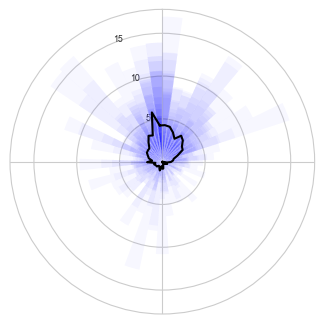

In [231]:
### Plot the viewing angels --> this will be edited afterwards to include nose
ids = recordings.index.tolist()
idd = ids[:]


# set fontsize: 
new_height_cm = 6.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
original_height_cm = 12 # adjust
original_fontsize = 40
# define
numbersize = 80 * (new_height_cm/60)# A, B etc.
labelsize = 40  * (new_height_cm/40)#text
legendsize = 40  * (new_height_cm/40)#ledgend
ticksize = 30  * (new_height_cm/30)#ticks
fname = "Arial" # font name

# set figure size
fig_width_cm = 8.5  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 30/30
fig_height_in = fig_width_in * aspect_ratio
#plt.figure(figsize=(30, 30), constrained_layout=True)
plt.figure(figsize=(fig_width_in, fig_height_in), constrained_layout=True)

sns.set_style("whitegrid") 
# grid to have the subplots arranged nicely
ax0 = plt.subplot2grid(shape=(1,1), loc=(0, 0), rowspan=1, colspan=1,polar=True)
ax = plt.subplot2grid(shape=(1,1), loc=(0, 0), rowspan=1, colspan=1,polar=True)

ax.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
# Create a polar plot for the average distribution


# Initialize data storage for averaging
all_histograms = []
num_participants = len(idd)

for uid in idd:
    
   
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

     # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows


    viewing_angle = []
    for r in range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        viewing_angle = viewing_angle + [(rotations[curr_name].tolist()[r] - yaw + 180) % 360]


    # Create a histogram of frequencies of viewing angles for participant
    bins = np.linspace(0, 360, num=46)  # 36 bins for 10-degree intervals (0-360)
    hist, edges = np.histogram(viewing_angle, bins=bins, density=False)

    # Calculate percentages
    total_count = np.sum(hist)  # Calculate the total count of observations
    percentage_hist = (hist / total_count) * 100  # Convert counts to percentages
    all_histograms.append(percentage_hist)

    # Calculate angles for polar plot based on the bins
    angles = edges[:-1] + np.diff(edges) / 2  # Midpoints for each bin
    angles = np.concatenate((angles, [angles[0]]))  # Close the circle
    percentage_hist = np.concatenate((percentage_hist, [percentage_hist[0]]))  # Repeat first value to close the circle
    
    #width = np.deg2rad(np.diff(edges))
    # Append the last width value to close the circle
    #width = np.concatenate((width, [width[-1]]))
    width = (2 * np.pi) / len(hist) *1.01 # 
    #ax.plot(np.deg2rad(angles), percentage_hist, 'b', linewidth=1, alpha=0.4)  # Line plot
    ax.bar(np.deg2rad(angles), percentage_hist, width=width, color='b', alpha=0.03)  # Fill the area

    

all_histograms = np.array(all_histograms)
average_histogram = np.median(all_histograms, axis=0)
# Calculate angles for polar plot based on the bins
angles = edges[:-1] + np.diff(edges) / 2  # Midpoints for each bin
angles = np.concatenate((angles, [angles[0]]))  # Close the circle
average_histogram = np.concatenate((average_histogram, [average_histogram[0]]))  # Repeat first value to close the circle
ax.plot(np.deg2rad(angles), average_histogram, 'k', linewidth=1.5)  # Line plot

# Set the labels and title for the entire plot
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Ticks every 30 degrees
ax.set_xticklabels([f"{int(angle)}°" for angle in np.arange(0, 360, 30)], fontsize=14)

ax.set_theta_zero_location("N")  # 0° (North) at the top
ax.set_yticks(np.arange(0, 20,5))  # Example with ticks up to the maximum value
ax.set_yticklabels(['','5', '10', '15',], fontsize=labelsize)  # Customize font size
#ax.set_yticklabels([])  # Hide radial labels

# Set labels at 0°, 90°, 180°, 270°
ax.set_xticks(np.radians([0, 90, 180, 270]))  
#ax.set_xticklabels(["0° (Front)", "90° (Right)", "180° (Back)", "270° (Left)"], fontsize=14)
ax.set_xticklabels([])

plt.tight_layout()
plt.savefig("./images/angelplot.png", bbox_inches="tight", pad_inches=0.1, dpi=1200)  
plt.show()

/tmp/ipykernel_1158411/3124299061.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frontal.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1158411/3124299061.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frontal_dist.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1158411/3124299061.py:117: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to th

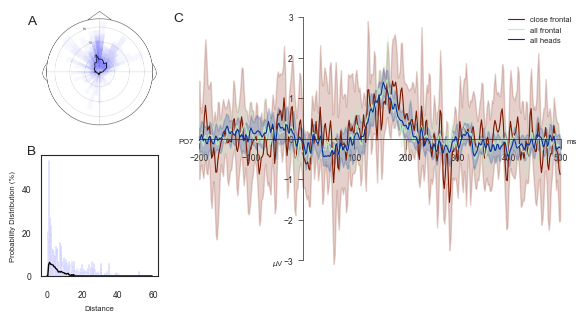

In [5]:
# set figure size
fig_width_cm = 17.6  # 1 column = 8.5; 1.5 columns = 11.6; 2 columns = 17.6
fig_width_in = fig_width_cm / 2.54
aspect_ratio = 20/40
fig_height_in = fig_width_in * aspect_ratio
# set up figure
# set up figure
rc = {"xtick.direction" : "inout", "ytick.direction" : "inout",
      "xtick.major.size" : fig_width_in, "ytick.major.size" : fig_height_in,
      "xtick.major.width" : 0.5, "ytick.major.width" : 0.5,
     "figure.figsize": (fig_width_in, fig_height_in)}
with plt.rc_context(rc):
    plt.figure()
    plt.tight_layout()  # Adjust subplot spacing dynamically
    sns.set_style("white") 

     # set fontsize: 
    new_height_cm = 7.39  # 1 column = 3.09; 1.5 columns = 4.22; 2 columns = 6.39
    original_height_cm = 30 # adjust
    # define
    numbersize = 80 * (new_height_cm/60)# A, B etc.
    labelsize = 30 * (new_height_cm/40)# text
    legendsize = 30 * (new_height_cm/40)# ledgend
    ticksize = 25 * (new_height_cm/30)# ticks
    fname = "Arial" # font name
    plt.rcParams["font.family"] = fname
    
    # set up grid
    ax0 = plt.subplot2grid(shape=(2,4), loc=(0, 0), rowspan=1, colspan=1)  
    ax1 = plt.subplot2grid(shape=(2,4), loc=(1, 0), rowspan=1, colspan=1)    
    ax2 = plt.subplot2grid(shape=(2,4), loc=(0, 1), rowspan=2, colspan=3)

    #ax1.set_aspect('auto') 

    # ax0, add image created above including the nose
    # done: uploaded to keynote, added nose, converted to pdf, cut into smaller image and saved with sufficuent dpi;
    # adjusted the black outline with procreate
    img = plt.imread("./images/angelplot400.png")
    ax0.imshow(img, alpha=1) 
    ax0.axis('off')


    # participants ids
    ids = recordings.index.tolist()
    idd = ids[:]
    # Initialize data storage for averaging
    all_histograms = []
    num_participants = len(idd)
    for uid in idd:       
        # load the behavioral data
        for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
        # get face gazes
        gaze = for_eye[for_eye["events"] == 2.0]
        gaze = gaze[~gaze["names"].isnull()]
        gaze = gaze[
            ~gaze["long_events"].isnull()
        ]  
        face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]
    
        # Create a histogram of frequencies of viewing angles for participant
        bins = np.linspace(0, 60, num=120)  # 36 bins for 10-degree intervals (0-360)
        hist, edges = np.histogram(face_gaze.distance.tolist(), bins=bins, density=False)
    
        # Calculate percentages
        total_count = np.sum(hist)  # Total count of observations
        percentage_hist = (hist / total_count) * 100  # Convert counts to percentages
        all_histograms.append(percentage_hist)
    
        # Plot individual participant's distribution
        ax1.bar(edges[:-1], percentage_hist, width=np.diff(edges), alpha=0.6, color='b')  # Plotting the histogram directly
        
    
    all_histograms = np.array(all_histograms)
    average_histogram = np.median(all_histograms, axis=0)
    ax1.plot(edges[:-1], average_histogram, 'k', linewidth=1)  # Line plot
    
    ax1.set_xlabel("Distance", fontsize=legendsize)
    ax1.set_ylabel("Probability Distribution (%)", fontsize=legendsize)   
    ax1.set_xticks([0,20,40,60],)
    ax1.set_yticks([0,20,40],)
    ax1.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
    ax1.xaxis.set_tick_params(labelsize=ticksize)
    



    # load the channel file & find the correct row
    chan = 'PO7'
    chanlocs = scipy.io.loadmat(f"/net/store/nbp/projects/wd_ride_village/Analysis/FacePaper/ERPs_without_Unfold/TFCE_resources/chanLocs.mat")
    chanlocs = chanlocs['chanLocs']
    chanlocs = np.array([item[0][:] for item in chanlocs['labels'][0]]).tolist()
    chanidx = chanlocs.index(chan) # index
    mat = scipy.io.loadmat(f"{PATH_EEG}/frontal_face_dist_erps_wo_Unfold.mat") # change this with a file just for that subject
    frontal = pd.DataFrame(mat['frontal_face_wo_unfold'][:,chanidx,:]).transpose()
    frontal_dist = pd.DataFrame(mat['frontal_face_dist_wo_unfold'][:,chanidx,:]).transpose()
    all_head = pd.DataFrame(mat['all_face_wo_unfold'][:,chanidx,:]).transpose()
    time = mat['times'][0].tolist()

    frontal['time'] = time
    frontal = frontal.set_index(['time']).transpose()
    frontal['subj'] = frontal.index.tolist()
    frontal = pd.melt(frontal, id_vars='subj', value_vars=time)

    frontal_dist['time'] = time
    frontal_dist = frontal_dist.set_index(['time']).transpose()
    frontal_dist['subj'] = frontal_dist.index.tolist()
    frontal_dist = pd.melt(frontal_dist, id_vars='subj', value_vars=time)

    all_head['time'] = time
    all_head = all_head.set_index(['time']).transpose()
    all_head['subj'] = all_head.index.tolist()
    all_head = pd.melt(all_head, id_vars='subj', value_vars=time)

    # Convert inf values to NaN
    frontal.replace([np.inf, -np.inf], np.nan, inplace=True)
    frontal_dist.replace([np.inf, -np.inf], np.nan, inplace=True)
    all_head.replace([np.inf, -np.inf], np.nan, inplace=True)
    #### plot the average ERP
    color = iter(cm.roma(np.linspace(0, 1, 3)))

    sns.lineplot(data=frontal_dist,x="time",y="value",color=next(color),linewidth=0.8,ax=ax2,label="close frontal")
    sns.lineplot(data=frontal,x="time",y="value",color=next(color),linewidth=0.8,ax=ax2,label="all frontal")
    sns.lineplot(data=all_head,x="time",y="value",color=next(color),linewidth=0.8,ax=ax2,label="all heads")

     # legend:
    handles, labels = ax2.get_legend_handles_labels()
    legend = ax2.legend(handles,labels,loc="upper right", fontsize=legendsize, frameon=False)
    # axis labels
    ax2.set_xlabel('    ')
    ax2.set_ylabel(u'$\it{\u03bc}$' + 'V', fontsize=labelsize, fontname=fname, loc='bottom', rotation = 0)
    ax2.yaxis.set_label_coords(0.230,0.03)
    ax2.text(-240,-0.12,"PO7", fontsize=labelsize)
    ax2.text(510,-0.12,"ms", fontsize=labelsize)
    # ticks
    x = [-200,-100,100,200,300,400,500]
    ax2.set_xticks(x)
    y = [-3.0,-2.0,-1.0,0,1.0,2.0,3.0]
    ax2.set_yticks(y)
    for label in ax2.get_xticklabels(): # change tick font
        label.set_fontproperties(fname)
    for label in ax2.get_yticklabels():
        label.set_fontproperties(fname)
    ax2.yaxis.set_tick_params(labelsize=ticksize)  # change tick size
    ax2.xaxis.set_tick_params(labelsize=ticksize)
    # adjust spines
    ax2.spines[['top','right']].set_visible(False)
    ax2.spines[['bottom','left']].set_linewidth(0.5)
    ax2.spines[['bottom','left']].set_position(('data', 0))
    ax2.spines[['bottom','left']].set_clip_on(True)
    ax2.spines[['left']].set_bounds([- 3.0,3.0])
    ax2.spines[['bottom']].set_bounds([- 200,500])
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    
    
ax0.set_title("A", fontsize=numbersize, fontweight="bold",loc="left", x=-0.12, y=1.25, pad=-30, fontname=fname)
ax1.set_title("B", fontsize=numbersize, fontweight="bold",loc="left", x=-0.12, y=1.35, pad=-30, fontname=fname) 
ax2.set_title("C", fontsize=numbersize, fontweight="bold",loc="left", x=-0.02, y=1.11, pad=-30, fontname=fname) 


plt.savefig("./images/fig_for_submission/Fig5_NEW_rotation_and_dist.png", bbox_inches="tight", pad_inches=0.3, dpi=400)  

plt.show()

# Calculate stats and numbers to report in the paper 

In [14]:
# Get median of distances 

# participants ids
ids = recordings.index.tolist()
idd = ids[:]
# Initialize data storage for averaging
all_histograms = []
for uid in idd:       
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]
    all_histograms = all_histograms + [np.nanmedian(face_gaze.distance.tolist())]
display(np.nanmedian(all_histograms))
mad_values = median_abs_deviation(all_histograms, scale='normal')
print(mad_values)

5.20914531334691

2.590610888906205


In [43]:
# Get circular mean of rotations

ids = recordings.index.tolist()
idd = ids[:]

all_histograms = []

for uid in idd:
    
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

     # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows

    sin_sum = 0 # sum all sine (x)
    cos_sum = 0 # sum all cosine (y)
    viewing_angle_count = 0 # count the number of angles --> to get average 
    for r in range(13):#range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        # Calculate the viewing angle and transfrom to radians 
        angle = np.radians((rotations[curr_name].tolist()[r] - yaw + 180) % 360)
        if not np.isnan(angle):
            sin_sum = sin_sum + np.sin(angle)
            cos_sum = cos_sum + np.cos(angle)
            viewing_angle_count += 1
    # now compute average 
    avg_sin = sin_sum / viewing_angle_count
    avg_cos = cos_sum / viewing_angle_count
    # and arctan for this participant and transfrom to degrees
    average_angle = np.degrees(np.arctan2(avg_sin, avg_cos))

    # normalize between 0 and 360:
    if average_angle < 0:
        average_angle = average_angle + 360

    all_histograms = all_histograms + [average_angle]

# now across participants, also compute the circular mean:
all_sin = np.sum(np.sin(np.radians(all_histograms)))/len(all_histograms)
all_cos = np.sum(np.cos(np.radians(all_histograms)))/len(all_histograms)
# take arctan and then transfrom the degree
overall_angle = np.degrees(np.arctan2(all_sin, all_cos))
# normalise between 0 and 360
if overall_angle < 0:
    overall_angle = overall_angle + 360

print("Circular Mean:", overall_angle)

# compute circular std
R = np.sqrt(all_sin**2 + all_cos**2) # resultant length
circular_std = np.degrees(np.sqrt(-2 * np.log(R)))

print("Circular Standard Deviation:", circular_std)        


Circular Mean: 13.20951711448161
Circular Standard Deviation: 30.868368915396598


In [42]:
R = np.sqrt(all_sin**2 + all_cos**2)
circular_std = np.degrees(np.sqrt(-2 * np.log(R)))
print("Circular Standard Deviation:", circular_std)        


Circular Standard Deviation: 30.868368915396598


In [38]:
all_sin

0.1976431198476373

In [22]:
# Get average number of trials per condtiion: frontal faces + frontal faces and close distance

ids = recordings.index.tolist()
idd = ids[:]

frontal = []
frontal_close = []
for uid in idd:
    # load the behavioral data
    for_eye = pd.read_csv(f"{PATH_FOREYE}/correTS_mad_wobig_{uid}.csv", index_col=0)
    # get face gazes
    gaze = for_eye[for_eye["events"] == 2.0]
    gaze = gaze[~gaze["names"].isnull()]
    gaze = gaze[
        ~gaze["long_events"].isnull()
    ]  
    face_gaze = gaze[gaze["names"].str.contains("face", regex=False, na=False)]

     # get pedestrian rotations
    rotations = pd.read_csv(f"{PATH_AGNT}/Pedestrians_{uid}_rotation.csv", index_col=0)
    rotations = rotations.loc[face_gaze.time] # only keep the time relevant rows


    viewing_angle = []
    for r in range(len(face_gaze)):
        # compute the participants gaze direction 
        yaw = math.degrees(math.atan2(face_gaze.xcoord.tolist()[r], face_gaze.zcoord.tolist()[r]))
        # make sure yaw is positive between 0 and 360
        if yaw < 0:
            yaw = yaw + 360

        # get the currently gazed at pedestrian direction
        curr_name = re.search(r"face_(\d+)", face_gaze.names.tolist()[r]).group(1)
        # calculate the viewing angel (angular difference between the pedestrian's facing direction and the participant's gaze)
        # Importantly, starting here, we will have face == 0/360 and back of the head == 180
        # Calculate the viewing angle
        viewing_angle = viewing_angle + [(rotations[curr_name].tolist()[r] - yaw + 180) % 360]

    face_gaze.loc[:,"viewing_angle"] = viewing_angle
    face_gaze = face_gaze[(face_gaze["viewing_angle"] < 45) | (face_gaze["viewing_angle"] >= 315)].copy()
    frontal = frontal + [len(face_gaze)]
    face_gaze = face_gaze[(face_gaze["distance"] <= 5)].copy()
    frontal_close = frontal_close + [len(face_gaze)]

print()
print("Frontal: ")
display(np.nanmedian(frontal))
print(median_abs_deviation(frontal, scale='normal'))
print()
print("Frontal AND close: ")
display(np.nanmedian(frontal_close))
print(median_abs_deviation(frontal_close, scale='normal'))


/tmp/ipykernel_597274/1028349035.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_gaze.loc[:,"viewing_angle"] = viewing_angle
/tmp/ipykernel_597274/1028349035.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_gaze.loc[:,"viewing_angle"] = viewing_angle
/tmp/ipykernel_597274/1028349035.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.


Frontal: 


/tmp/ipykernel_597274/1028349035.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_gaze.loc[:,"viewing_angle"] = viewing_angle


72.0

63.75189539574088

Frontal AND close: 


39.0

38.54765768114565
